In [6]:
import re
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [47]:
def list_dataset():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]
    
IMAGES_DIR = '/Users/rosaria/Desktop/data/archive (2)/Garbage classification/Garbage classification/'
    
train_file = '/Users/rosaria/Desktop/data/archive (2)/one-indexed-files-notrash_train.txt'
val_file   = '/Users/rosaria/Desktop/data/archive (2)/one-indexed-files-notrash_val.txt'
test_file  = '/Users/rosaria/Desktop/data/archive (2)/one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])

df_train = add_class_name_prefix(df_train, 'rel_path')
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_test  = add_class_name_prefix(df_test,  'rel_path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} test samples.')

Found 1768 training, 328 validation and 328 test samples.


In [7]:
datagen = ImageDataGenerator()

datagen_train = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

datagen_valid = datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


## Model1: ResNet50

In [9]:
def build_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
        
    return model


net = build_model(num_classes=6)

net.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.categorical_accuracy])

net.summary()

94773248/94765736 [==============================] - 13s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = net.fit_generator(
    generator=datagen_train,
    validation_data=datagen_valid,
    epochs=30,
    validation_freq=1,
    callbacks=[early_stop]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
56/56 [==============================] - 136s 2s/step - loss: 1.0176 - categorical_accuracy: 0.6895 - val_loss: 0.4305 - val_categorical_accuracy: 0.8476
Epoch 2/30
56/56 [==============================] - 136s 2s/step - loss: 0.3134 - categorical_accuracy: 0.8908 - val_loss: 0.4173 - val_categorical_accuracy: 0.8659
Epoch 3/30
56/56 [==============================] - 147s 3s/step - loss: 0.2071 - categorical_accuracy: 0.9310 - val_loss: 0.3963 - val_categorical_accuracy: 0.8537
Epoch 4/30
56/56 [==============================] - 138s 2s/step - loss: 0.1252 - categorical_accuracy: 0.9649 - val_loss: 0.3252 - val_categorical_accuracy: 0.8872
Epoch 5/30
56/56 [==============================] - 132s 2s/step - loss: 0.0747 - categorical_accuracy: 0.9830 - val_loss: 0.3579 - val_categorical_accuracy: 0.8872
Epoch 6/30
56/56 [==============================] - 135s 2s/step - loss: 0.0523 - categorical_accur

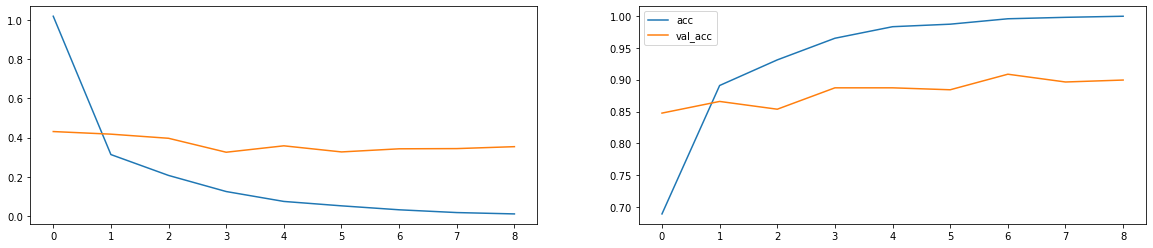

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')

axs[1].plot(history.history['categorical_accuracy'], label='acc')
axs[1].plot(history.history['val_categorical_accuracy'], label='val_acc')

plt.legend();
plt.show();

In [12]:
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=7
)

# y_pred = net.predict(test_generator, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

filenames = test_generator.filenames
nb_samples = len(filenames)

net.evaluate_generator(test_generator, nb_samples)


Found 328 validated image filenames belonging to 6 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.3252413868904114, 0.8871951103210449]

## Model2: VGG16 + Classifier

In [13]:
# Show pictures
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

### Example pictures

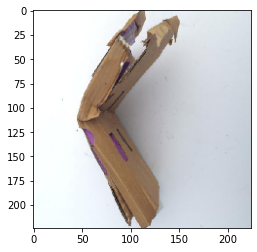

cardboard


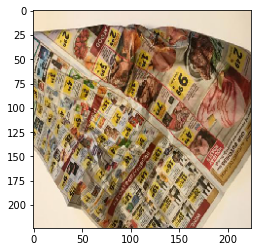

paper


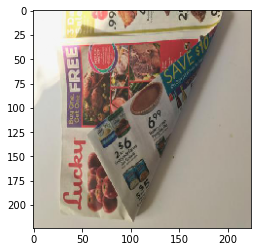

paper


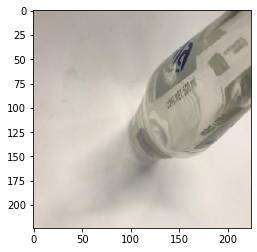

glass


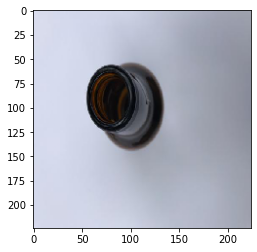

glass


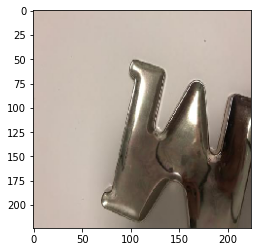

metal


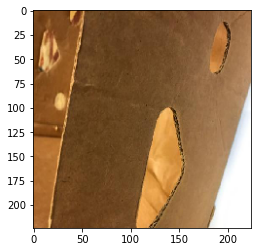

cardboard


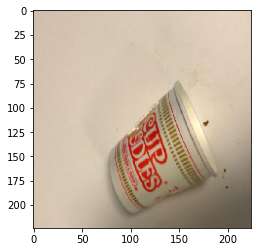

trash


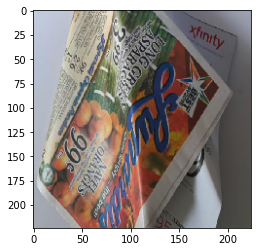

paper


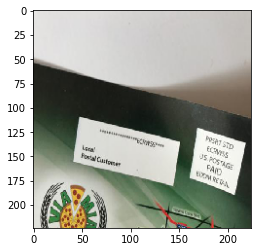

paper


In [124]:
df_train.head()

img_width, img_height = 224, 224  # Default input size for VGG1

for i in range(0,10):
    IMAGES_DIR2 = '/Users/rosaria/Desktop/data/archive (2)/Garbage classification/'
    img_path = os.path.join(IMAGES_DIR, df_train.iloc[i,0])
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)
    img_tensor /= 255.
    plt.imshow(img_tensor)
    plt.show()
    print(df_train.iloc[i,1])

### Extract features

In [44]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

58892288/58889256 [==============================] - 73s 1us/step


In [45]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [48]:
#base_dir = '/Users/macbook/book/dogs_cats/data'
#train_dir = os.path.join(base_dir, 'train')
#validation_dir = os.path.join(base_dir, 'validation')
#test_dir = os.path.join(base_dir, 'test')
#train_cats_dir = os.path.join(train_dir, 'cats')
#btrain_dogs_dir = os.path.join(train_dir, 'dogs')

train_size, validation_size, test_size = 1768, 328, 328

In [75]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(data_type, directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count, 6))
    # Preprocess data
    generator = datagen.flow_from_dataframe(dataframe=data_type,
                                            directory=directory,
                                            x_col='rel_path',
                                            y_col='label',
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(df_train, IMAGES_DIR, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(df_valid, IMAGES_DIR, validation_size)
test_features, test_labels = extract_features(df_test, IMAGES_DIR, test_size)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


In [76]:
print(train_features[:3])
print(train_labels[:3])

[[[[0.1081183  0.         0.         ... 0.         0.67809922
    0.        ]
   [0.         0.         0.         ... 0.         0.62438768
    0.        ]
   [0.         0.         0.         ... 0.         0.6346122
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.68340164
    0.        ]
   [0.         0.         0.         ... 0.         0.71918607
    0.        ]
   [0.11688994 0.         0.         ... 0.         0.78053963
    0.        ]]

  [[0.08041843 0.         0.         ... 0.         0.43944412
    0.        ]
   [0.01607729 0.         0.79445416 ... 0.         0.3670539
    0.        ]
   [0.40793926 0.         1.04933572 ... 0.07558048 0.4913882
    0.        ]
   ...
   [0.01059857 0.         0.         ... 0.         0.73734313
    0.        ]
   [0.09976257 0.         0.         ... 0.         0.61511886
    0.        ]
   [0.05443004 0.         0.         ... 0.         0.67407084
    0.        ]]

  [[0.20986016 0.         0.         

### Modeling 1: NN

In [82]:
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='reluimport xgboost', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 1542      
Total params: 6,424,326
Trainable params: 6,424,326
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [84]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))


Epoch 1/100
56/56 [==============================] - 2s 38ms/step - loss: 0.5315 - acc: 0.4214 - val_loss: 0.2822 - val_acc: 0.6098
Epoch 2/100
56/56 [==============================] - 2s 36ms/step - loss: 0.2869 - acc: 0.6386 - val_loss: 0.2535 - val_acc: 0.6799
Epoch 3/100
56/56 [==============================] - 2s 36ms/step - loss: 0.2450 - acc: 0.7081 - val_loss: 0.2231 - val_acc: 0.7256
Epoch 4/100
56/56 [==============================] - 2s 37ms/step - loss: 0.2128 - acc: 0.7579 - val_loss: 0.2114 - val_acc: 0.7409
Epoch 5/100
56/56 [==============================] - 2s 39ms/step - loss: 0.1865 - acc: 0.7885 - val_loss: 0.2156 - val_acc: 0.7378
Epoch 6/100
56/56 [==============================] - 2s 38ms/step - loss: 0.1597 - acc: 0.8399 - val_loss: 0.2149 - val_acc: 0.7439
Epoch 7/100
56/56 [==============================] - 2s 38ms/step - loss: 0.1418 - acc: 0.8541 - val_loss: 0.2232 - val_acc: 0.7409
Epoch 8/100
56/56 [==============================] - 2s 37ms/step - loss: 0.

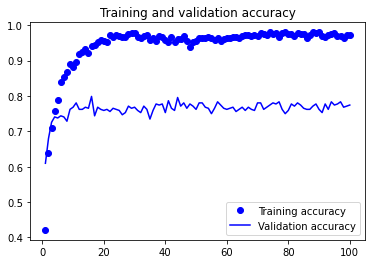

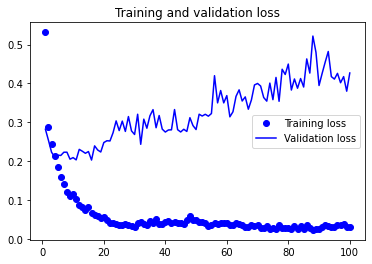

In [85]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [93]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))
print(svm_features.shape, svm_labels.shape)

(2096, 7, 7, 512) (2096, 6)


### Modeling 2: SVM

In [97]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

svm_labels_class = np.argmax(svm_labels, axis=1).reshape(-1,1)
print(svm_labels_class)
X_train, y_train = svm_features.reshape(1768+328, 7*7*512), svm_labels_class

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge')  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
clf.fit(X_train, y_train)

[[1]
 [4]
 [0]
 ...
 [5]
 [2]
 [4]]


/Users/rosaria/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/rosaria/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rosaria/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/rosaria/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rosaria/o

GridSearchCV(cv=10, estimator=LinearSVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}])

In [100]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
print(np.mean(cross_val_score(clf, X_train, y_train)))
#print("\nAccuracy score (standard deviation):")
#print(np.std(cross_val_score(clf, X_train, y_train, cv=10)))


Accuracy score (mean):


/Users/rosaria/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/rosaria/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rosaria/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/rosaria/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rosaria/o

KeyboardInterrupt: 

###  Modelling 3: XGBoost

In [103]:
import xgboost
xgb_model = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb_model.fit(X_train,y_train)

/Users/rosaria/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.75,
              tree_method='exact', validate_parameters=1, verbosity=None)

<Figure size 4320x720 with 0 Axes>

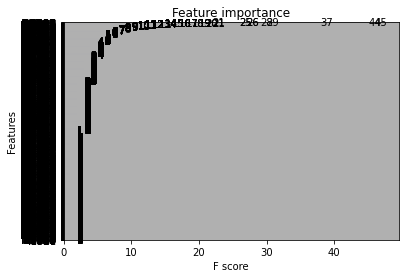

In [123]:
xgboost.plot_importance(xgb_model)

In [107]:
X_test = test_features.reshape(328, 7*7*512)
y_test = np.argmax(test_labels, axis=1).reshape(-1,1)

In [121]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

predictions = xgb_model.predict(X_test)
predictions

def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    
get_clf_eval(y_test, predictions)

오차행렬:
 [[46  0  0  0  0  0]
 [ 0 65  0  0  0  0]
 [ 0  0 56  0  0  0]
 [ 0  0  0 83  0  0]
 [ 0  1  0  0 60  0]
 [ 0  0  0  0  0 17]]

정확도: 0.9970


## Result 

In [153]:
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        #path = random.choice([cardboard, glass, metal, paper, plastic, trash])

        # Get picture
        j = random.choice(range(300))
        img_path = os.path.join(IMAGES_DIR, df_test.iloc[j,0])
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction == 0:
            print('Cardboard')
        elif prediction == 1:
            print('Glass')
        elif prediction == 2:
            print('Metal')
        elif prediction == 3:
            print('Paper')
        elif prediction == 4:
            print('Plastic')
        elif prediction == 5:
            print('Trash')

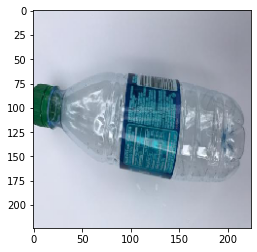

Plastic


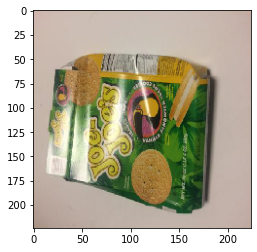

Paper


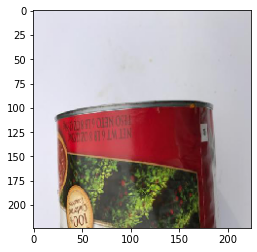

Metal


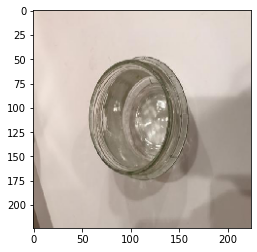

Glass


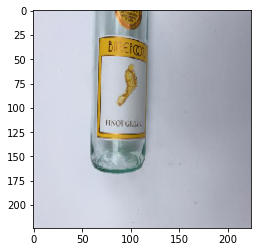

Glass


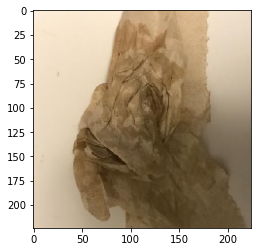

Trash


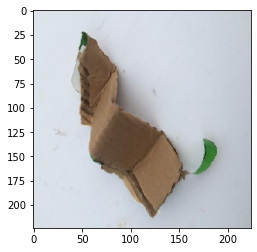

Cardboard


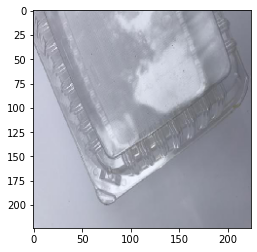

Plastic


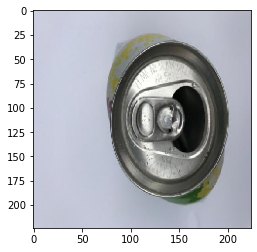

Metal


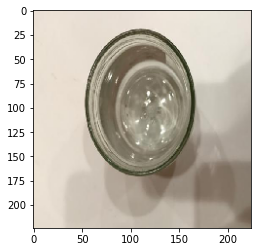

Glass


In [155]:
visualize_predictions(xgb_model, 10)